<a href="https://colab.research.google.com/github/KeenBean024/VisionRAG/blob/main/CS7290_VisionRAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!sudo apt-get update
!apt-get install poppler-utils
!pip install colpali-engine
!pip install pdf2image


Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,375 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,748 kB]
Get:13 http://security.ubuntu.

In [2]:
from flask import Flask, request, jsonify
from typing import Any, List, cast
import h5py
from colpali_engine.utils.torch_utils import get_torch_device
from peft import LoraConfig
from PIL import Image
from colpali_engine.models import ColQwen2, ColQwen2Processor
from transformers.models.qwen2_vl import Qwen2VLForConditionalGeneration, Qwen2VLProcessor
import torch
import os
from pdf2image import convert_from_path
import traceback
import numpy as np
import cv2
import base64
import ipywidgets as widgets
from IPython.display import display
from tqdm import tqdm
import gc
from io import BytesIO

ModuleNotFoundError: No module named 'colpali_engine'

In [ ]:
class ColQwen2ForRAG(ColQwen2):
    """
    ColQwen2 model implementation that can be used both for retrieval and generation.
    Allows switching between retrieval and generation modes.
    """

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._is_retrieval_enabled = True

    def forward(self, *args, **kwargs) -> Any:
        """
        Forward pass that calls either Qwen2VLForConditionalGeneration.forward for generation
        or ColQwen2.forward for retrieval based on the current mode.
        """
        if self.is_retrieval_enabled:
            return ColQwen2.forward(self, *args, **kwargs)
        else:
            return Qwen2VLForConditionalGeneration.forward(self, *args, **kwargs)

    def generate(self, *args, **kwargs):
        """
        Generate text using Qwen2VLForConditionalGeneration.generate.
        """
        if not self.is_generation_enabled:
            raise ValueError(
                "Set the model to generation mode by calling `enable_generation()` before calling `generate()`."
            )
        return super().generate(*args, **kwargs)

    @property
    def is_retrieval_enabled(self) -> bool:
        return self._is_retrieval_enabled

    @property
    def is_generation_enabled(self) -> bool:
        return not self.is_retrieval_enabled

    def enable_retrieval(self) -> None:
        """
        Switch to retrieval mode.
        """
        self.enable_adapters()
        self._is_retrieval_enabled = True

    def enable_generation(self) -> None:
        """
        Switch to generation mode.
        """
        self.disable_adapters()
        self._is_retrieval_enabled = False




In [3]:
################### Setup Model and Processor ############################
model_name = "vidore/colqwen2-v1.0"
device = get_torch_device("auto")
torch.cuda.empty_cache()
print(f"Using device: {device}")

NameError: name 'get_torch_device' is not defined

In [4]:
lora_config = LoraConfig.from_pretrained(model_name)

# Load the processors
processor_retrieval = cast(ColQwen2Processor, ColQwen2Processor.from_pretrained(model_name))
processor_generation = cast(Qwen2VLProcessor, Qwen2VLProcessor.from_pretrained(lora_config.base_model_name_or_path))

model = cast(
    ColQwen2ForRAG,
    ColQwen2ForRAG.from_pretrained(
        model_name,
        torch_dtype=torch.bfloat16,
        device_map=device,
    ),
)
model = model.eval()


NameError: name 'LoraConfig' is not defined

In [5]:
IMAGE_HEIGHT = 1024
RETRIEVE_K = 2
BATCH_SIZE = 1
SCALE_IMAGE = True
KNOWLEDGE_BASE = "knowledge_base.h5"
ROW_SIZE = 128  # The last dimension is fixed

# Define a fixed-size array dtype for a row of embedding (128 float32s)
row_dtype = np.dtype((np.float32, (ROW_SIZE,)))
# Create a variable-length dtype based on that fixed-size type:
vlen_float_dtype = h5py.special_dtype(vlen=np.dtype('float32'))

print(f"Using image scaling: {SCALE_IMAGE}")
print(f"Using batch size: {BATCH_SIZE}")
print(f"Using retrieve k: {RETRIEVE_K}")
print(f"Using image height: {IMAGE_HEIGHT}")

NameError: name 'np' is not defined

In [31]:
# def process_pdf(file_path):
#     """
#     Process a PDF file by extracting pages and running them through ColQwen2 for retrieval.
#     Uses a generator to reduce peak RAM usage.
#     """
#     print("Starting PDF to image conversion")

#     # Convert PDF pages to images one at a time to save memory
#     images_gen = convert_from_path(file_path)

#     page_embeddings = []

#     for i, image in tqdm(enumerate(images_gen)):
#         # Scale each image immediately to reduce memory footprint
#         if SCALE_IMAGE:
#             image = scale_image(image, new_height=IMAGE_HEIGHT)

#         model.enable_retrieval()
#         data = processor_retrieval.process_images([image])

#         with torch.no_grad():
#             batch_doc = {k: v.to(model.device) for k, v in data.items()}
#             embedding = model(**batch_doc).cpu().float().numpy()
#         print(f"Embedding shape - {embedding.shape}")
#         page_embeddings.append(embedding)

#         # Cleanup memory
#         del data, batch_doc, embedding, image
#         torch.cuda.empty_cache()
#         gc.collect()

#     # Concatenate embeddings from all pages
#     return images_gen, np.concatenate(page_embeddings, axis=0)

def process_pdf(file_path):
    """
    Process a PDF file page by page, extract embeddings, and store embeddings and images in HDF5.
    Each page's embedding is expected to have shape (1, N, 128); after dropping the batch dimension,
    we get (N, 128). We then flatten it to a 1D array (of length N*128) and store the number N in a separate dataset.
    """
    print("Starting PDF processing...")
    images_gen = convert_from_path(file_path)

    with h5py.File(KNOWLEDGE_BASE, 'a') as f:
        filename = os.path.basename(file_path)
        if filename in f:
            del f[filename]
        group = f.create_group(filename)

        # Create extendable dataset for flattened embeddings.
        vector_dataset = group.create_dataset(
            "vectors",
            shape=(0,),
            maxshape=(None,),
            dtype=vlen_float_dtype,
            compression="gzip"
        )
        # Dataset to store the number of rows (N) for each page's embedding.
        shape_dataset = group.create_dataset(
            "vector_shapes",
            shape=(0,),
            maxshape=(None,),
            dtype=np.int32,
            compression="gzip"
        )
        # Create extendable dataset for images as variable-length arrays of bytes.
        image_dtype = h5py.special_dtype(vlen=np.dtype('uint8'))
        image_dataset = group.create_dataset(
            "images",
            shape=(0,),
            maxshape=(None,),
            dtype=image_dtype
        )
        model.enable_retrieval()

        for i, image in tqdm(enumerate(images_gen), desc="Processing pages"):
            if SCALE_IMAGE:
                image = scale_image(image, new_height=IMAGE_HEIGHT)

            data = processor_retrieval.process_images([image])
            with torch.no_grad():
                batch_doc = {k: v.to(model.device) for k, v in data.items()}
                embedding = model(**batch_doc).cpu().float().numpy()
            # Drop the redundant batch dimension: expected shape becomes (N, 128)
            embedding = embedding[0]
            print(f"Embedding shape - {embedding.shape}")  # e.g. (779, 128)

            # Flatten the embedding: (N, 128) -> (N*128,)
            flat_embedding = embedding.flatten()

            # Convert image to compressed JPEG bytes
            img_buffer = BytesIO()
            image.save(img_buffer, format="JPEG", quality=75)
            img_bytes = np.frombuffer(img_buffer.getvalue(), dtype=np.uint8)

            # Extend datasets dynamically
            vector_dataset.resize((i + 1,))
            shape_dataset.resize((i + 1,))
            image_dataset.resize((i + 1,))

            vector_dataset[i] = flat_embedding.tolist()
            shape_dataset[i] = embedding.shape[0]  # number of rows N
            image_dataset[i] = img_bytes

            # Cleanup
            del data, batch_doc, embedding, flat_embedding, image, img_buffer, img_bytes
            torch.cuda.empty_cache()
            gc.collect()

    print(f"PDF processing complete. Data stored in group '{filename}'")

def process_query(query):
    """
    Process a query by running it through ColQwen2 for retrieval.

    Args:
        query (str): The query string.

    Returns:
        torch.Tensor: The embedding of the query as a tensor with shape (1, embedding_dim).
    """
    data = processor_retrieval.process_queries([query])
    model.enable_retrieval()
    with torch.no_grad():
        batch_doc = {k: v.to(model.device) for k, v in data.items()}
        embeddings_doc = model(**batch_doc)
    return embeddings_doc.cpu().float().numpy()

def get_embeddings_by_filename(filename):
    with h5py.File(KNOWLEDGE_BASE, 'r') as f:
        if filename not in f:
            raise ValueError(f"Filename {filename} not found in knowledge base.")
        group = f[filename]
        vectors = group['vectors']
        shapes = group['vector_shapes']
        embeddings = []
        # Reconstruct each page's embedding from the flattened data.
        for i in range(vectors.shape[0]):
            flat_embedding = np.array(vectors[i], dtype=np.float32)
            # Retrieve the number of rows (N) stored for this page.
            N = int(shapes[i])
            # Reshape flat_embedding (of length N*128) to (N, 128)
            embedding = flat_embedding.reshape(N, ROW_SIZE)
            embeddings.append(embedding)
        return np.array(embeddings)

def get_image_by_filename(filename, page_index):
    with h5py.File(KNOWLEDGE_BASE, 'r') as f:
        if filename not in f:
            raise ValueError(f"Filename {filename} not found in knowledge base.")
        # Retrieve image bytes for the specified page.
        img_bytes = bytes(f[filename]['images'][page_index])
        return Image.open(BytesIO(img_bytes))


# def get_data_by_filename(filename):
#     """
#     Retrieve vector and image data from the knowledge base HDF5 file for a given filename.

#     Args:
#         filename (str): The name of the file to look up in the HDF5 knowledge base.

#     Returns:
#         tuple: A tuple containing the vector data and image data if the filename is found,
#                or None if the filename is not present in the knowledge base.
#     """

#     with h5py.File(os.path.join('data','knowledge_base.h5'), 'r') as f:
#         if filename in f:
#             return f[filename]['vector'][()], f[filename]['image'][()]
#         else:
#             raise ValueError(f"Filename {filename} not found in knowledge base.")

def scale_image(image: Image.Image, new_height: int = 1024) -> Image.Image:
    """
    Scale an image to a new height while maintaining the aspect ratio.
    """
    width, height = image.size
    aspect_ratio = width / height
    new_width = int(new_height * aspect_ratio)

    return image.resize((new_width, new_height))

# def store_vector(filename, vector_data, image_data):
#     """
#     Stores the vector data for a given filename in an HDF5 file called 'vectors.h5'.

#     Args:
#         filename (str): The filename of the PDF file.
#         vector_data (list): The vector data to store.

#     Returns:
#         None
#     """
#     os.makedirs('data', exist_ok=True)
#     with h5py.File(os.path.join('data','knowledge_base.h5'), 'a') as f:
#         # Create a group for each filename if it doesn't exist
#         if filename not in f:
#             group = f.create_group(filename)
#         else:
#             group = f[filename]

#         # Store the vector data
#         if 'vector' in group:
#             del group['vector']  # Delete existing dataset if it exists

#         # Store the vector data
#         if 'image' in group:
#             del group['image']  # Delete existing dataset if it exists
#         group.create_dataset('vector', data=vector_data)
#         group.create_dataset('image', data=image_data)
#     print(f"Stored vector data for {filename} in knowledge base.")

def generate_answer(query, images):
    """
    Generates an answer to a given query using input images and a Retrieval-Augmented Generation (RAG) model.

    Args:
        query (str): The question or query that needs to be answered.
        images (torch.Tensor): The tensor containing image data to be used for answering the query.

    Returns:
        List[str]: A list of generated text responses based on the input query and images.
    """

    conversation = [
        {
            "role": "user",
            "content": [
                *[
                    {"type": "image"}
                    for _ in images
                ],
                {
                    "type": "text",
                    "text": f"Answer the following question using the input images: {query}",
                },
            ],
        }
    ]
    text_prompt = processor_generation.apply_chat_template(conversation, add_generation_prompt=True)
    inputs_generation = processor_generation(
        text=[text_prompt],
        images=images,
        padding=True,
        return_tensors="pt",
    ).to(device)

    # Generate the RAG response
    model.enable_generation()
    output_ids = model.generate(**inputs_generation, max_new_tokens=100)

    # Ensure that only the newly generated token IDs are retained from output_ids
    generated_ids = [output_ids[len(input_ids) :] for input_ids, output_ids in zip(inputs_generation.input_ids, output_ids)]

    # Decode the RAG response
    output_text = processor_generation.batch_decode(
        generated_ids,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=True,
    )

    del inputs_generation, output_ids, generated_ids
    torch.cuda.empty_cache()

    return output_text

def ndarray_to_base64(ndarr: np.ndarray, image_format: str = 'png') -> str:
    """
    Convert a NumPy ndarray (image) to a base64 encoded string.

    Args:
        ndarr (np.ndarray): The input image as a NumPy array.
        image_format (str): Format to encode the image (default is 'png').

    Returns:
        str: The base64 encoded string of the image.
    """
    # Encode the numpy array into the specified image format
    success, buffer = cv2.imencode(f'.{image_format}', ndarr)
    if not success:
        raise ValueError("Failed to encode image")

    # Convert buffer to bytes and then encode to base64 string
    img_bytes = buffer.tobytes()
    base64_str = base64.b64encode(img_bytes).decode('utf-8')
    return base64_str


## Upload PDF

In [1]:
# @title Upload PDF to knowledge base {"vertical-output":true}
file_path = "/content/03_chubb_limited_annual_report_2023.pdf" # @param {"type":"string"}
os.makedirs('uploads', exist_ok=True)

# Process with ColQwen2 retrieval model
process_pdf(file_path)

# Store in HDF5
# store_vector(os.path.basename(file_path), page_embeddings, images)

# del images, page_embeddings
torch.cuda.empty_cache()

NameError: name 'os' is not defined

In [56]:
# query = "What is the name of the company?"
# filename = "Chubb-Limited-Investor-Presentation-December-2023-short.pdf"
# query_embedding = process_query(query)
# image_embedding = get_embeddings_by_filename(filename)
# image_embedding = get_embeddings_by_filename(filename)
# # image_embedding, images = get_data_by_filename(filename)
# scores = processor_retrieval.score_multi_vector(
#       torch.from_numpy(query_embedding),
#       torch.from_numpy(image_embedding)
#   )
# top_pages = scores.numpy()[0].argsort()[-RETRIEVE_K:][::-1]
# print(f'Top pages: {top_pages}')
# # images = [get_image_by_filename(filename, page) for page in top_pages]
# # print(f'Images: {type(images)}')
# # answer = generate_answer(query, images)

In [57]:
filenames = ['a', 'b', 'c']
try:
    with h5py.File(KNOWLEDGE_BASE, 'r') as f:
        filenames = list(f.keys())
except:
    pass

# Create dropdown for file selection
file_picker = widgets.Dropdown(options=filenames, description='Select File:')

# Create text input box
text_input = widgets.Text(description='Input Query:')

# Create submit button
submit_button = widgets.Button(description='Submit')

def on_submit(b):
  print(f'Selected file: {file_picker.value}')
  print(f'User input: {text_input.value}')
  query = text_input.value
  filename = file_picker.value
  try:
    query_embedding = process_query(query)
    image_embedding = get_embeddings_by_filename(filename)
    # image_embedding, images = get_data_by_filename(filename)
    scores = processor_retrieval.score_multi_vector(
          torch.from_numpy(query_embedding),
          torch.from_numpy(image_embedding)
      )
    top_pages = scores.numpy()[0].argsort()[-RETRIEVE_K:][::-1]
    print(f'Top pages: {top_pages}')
    images = [get_image_by_filename(filename, page) for page in top_pages]
    print(f'Images: {type(images)}')
    answer = generate_answer(query, images)
    print(f'Answer: {answer}')
  except Exception as e:
    print(f'Error: {e}')
    traceback.print_exc()

submit_button.on_click(on_submit)

# Display widgets
display(file_picker, text_input, submit_button)


Selected file: Chubb-Limited-Investor-Presentation-December-2023.pdf
User input: What Percentage of income came from Agriculture?
Top pages: [13 17]
Images: <class 'list'>
Answer: ['The income from Agriculture was 4.4% of the total income.']


Dropdown(description='Select File:', options=('Chubb-Limited-Investor-Presentation-December-2023-short.pdf', '…

Text(value='', description='Input Query:')

Button(description='Submit', style=ButtonStyle())

## Image retrieval

In [12]:
dir(processor_retrieval)

['__abstractmethods__',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_auto_class',
 '_create_repo',
 '_get_arguments_from_pretrained',
 '_get_files_timestamps',
 '_merge_kwargs',
 '_upload_modified_files',
 'apply_chat_template',
 'attributes',
 'batch_decode',
 'chat_template',
 'decode',
 'factor',
 'feature_extractor_class',
 'from_args_and_dict',
 'from_pretrained',
 'get_image_mask',
 'get_n_patches',
 'get_processor_dict',
 'image_processor',
 'image_processor_class',
 'image_token',
 'image_token_id',
 'max_pixels',
 'max_ratio',
 'min_pixels',
 'model_input_names',
 'optional_attr

In [13]:
def process_image(image):
    """
    Process a image by running it through ColQwen2 for retrieval.

    Args:
        image : The image.

    Returns:
        torch.Tensor: The embedding of the image as a tensor with shape (1, embedding_dim).
    """
    data = processor_retrieval.process_images(image)
    model.enable_retrieval()
    with torch.no_grad():
        batch_doc = {k: v.to(model.device) for k, v in data.items()}
        embeddings_doc = model(**batch_doc)
    return embeddings_doc.cpu().float().numpy()

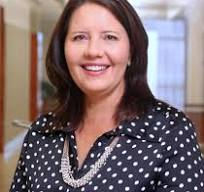

In [27]:
from PIL import Image

image = Image.open("/content/judy gonsalez.jpeg")
image

In [28]:
image_embedding = process_image([image])
print(image_embedding.shape)

(1, 60, 128)


In [29]:
filename = "03_chubb_limited_annual_report_2023.pdf"
query_embedding = image_embedding
image_embedding = get_embeddings_by_filename(filename)
# image_embedding, images = get_data_by_filename(filename)
scores = processor_retrieval.score_multi_vector(
      torch.from_numpy(query_embedding),
      torch.from_numpy(image_embedding)
  )
top_pages = scores.numpy()[0].argsort()[-RETRIEVE_K:][::-1]
print(f'Top pages: {top_pages}')
# images = [get_image_by_filename(filename, page) for page in top_pages]
# print(f'Images: {type(images)}')


Top pages: [ 4 30]


In [26]:
scores.numpy()[0][30]

216.89801

In [ ]:
images = [get_image_by_filename(filename, page) for page in top_pages]
for image in images:
  print(image)
print(f'Images: {type(images)}')

In [ ]:
answer = generate_answer(query, images)
print(f'Answer: {answer}')